**Idx-aware GFN for better sample diversity**

First experiments in the hypergrid toy environment

**Sanity check for a GFN that is not parameterized with the idx**

In [1]:
# Imports
import torch
import wandb
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

from gfn import LogitPBEstimator, LogitPFEstimator, LogZEstimator
from gfn.envs import HyperGrid, IdxAwareHyperGrid
from gfn.losses import TBParametrization, TrajectoryBalance
from gfn.samplers import DiscreteActionsSampler, TrajectoriesSampler
from gfn.utils import validate

device_str = "cuda" if torch.cuda.is_available() else "cpu"

/home/mila/v/vincent.quirion/.conda/envs/gfnenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
batch_size = 16

env = HyperGrid(ndim=2, height=8, R0=0.01, preprocessor_name="OneHot")

logit_PF = LogitPFEstimator(env=env, module_name="NeuralNet")

logit_PB = LogitPBEstimator(
    env=env,
    module_name="NeuralNet",
    torso=logit_PF.module.torso,  # To share parameters between PF and PB
)
logZ = LogZEstimator(torch.tensor(0.0))

parametrization = TBParametrization(logit_PF, logit_PB, logZ)

actions_sampler = DiscreteActionsSampler(estimator=logit_PF)
trajectories_sampler = TrajectoriesSampler(env=env, actions_sampler=actions_sampler)

loss_fn = TrajectoryBalance(parametrization=parametrization)

params = [
    {
        "params": [
            val for key, val in parametrization.parameters.items() if key != "logZ"
        ],
        "lr": 0.001,
    },
    {"params": [parametrization.parameters["logZ"]], "lr": 0.1},
]
optimizer = torch.optim.Adam(params)

for i in (pbar := tqdm(range(1000))):
    idxs = torch.arange(batch_size, device=env.device)
    trajectories = trajectories_sampler.sample(n_trajectories=batch_size)
    optimizer.zero_grad()
    loss = loss_fn(trajectories)
    loss.backward()
    optimizer.step()
    if i % 25 == 0:
        pbar.set_postfix({"loss": loss.item()})

trajectories_sampler0 = trajectories_sampler

100%|██████████| 1000/1000 [00:17<00:00, 56.83it/s, loss=5.42e-5]


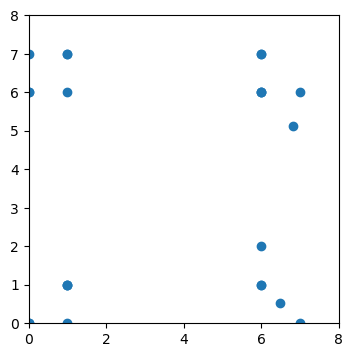

In [17]:
# Show sample distribution

# Set the figure size
plt.rcParams["figure.figsize"] = [4, 4]

trajectories = trajectories_sampler0.sample(n_trajectories=24)


data = trajectories.last_states.states_tensor.numpy()
# Adding noise to see more points
data = data.astype("float64")
data[0] += np.random.uniform(low=-1, high=1, size=data[0].size)
data[1] += np.random.uniform(low=-1, high=1, size=data[1].size)


plt.scatter(x=data[:, 0], y=data[:, 1])
plt.plot()
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.show()

**Same environment with simple reward sharing reward function**


In a 2-dim hypergrid with a batch size of 4 (= to the number of modes), the basic "penalize if equal to a previous sample in the batch" strategy fails. The policy samples from the right distribution but with decreasing "precision" as we increase the idx. The target distribution from which the samples are from do not seem to be impacted by the idx. This is probably because the policy learned for the first idx (idx=0) is allowed to sample from every mode of the distribution and the others are also allowed to, but they get penalized at random depending on the what is sampled with idx=0.

In [2]:
gfn.config.batch_size = batch_size = 4

env = IdxAwareHyperGrid(ndim=2, height=8, R0=0.01, preprocessor_name="OneHot")

logit_PF = LogitPFEstimator(env=env, module_name="IdxAwareNeuralNet", batch_size=batch_size)

logit_PB = LogitPBEstimator(
    env=env,
    module_name="IdxAwareNeuralNet",
    torso=logit_PF.module.torso,  # To share parameters between PF and PB
    batch_size=batch_size,
    embedding_layer=logit_PF.module.idx_embedding_layer, # To share parameters between PF and PB
)
logZ = LogZEstimator(torch.tensor(0.0))

parametrization = TBParametrization(logit_PF, logit_PB, logZ)

actions_sampler = DiscreteActionsSampler(estimator=logit_PF)
trajectories_sampler = TrajectoriesSampler(env=env, actions_sampler=actions_sampler)

loss_fn = TrajectoryBalance(parametrization=parametrization)

params = [
    {
        "params": [
            val for key, val in parametrization.parameters.items() if key != "logZ"
        ],
        "lr": 0.001,
    },
    {"params": [parametrization.parameters["logZ"]], "lr": 0.1},
]
optimizer = torch.optim.Adam(params)

for i in (pbar := tqdm(range(10000))):
    idxs = torch.arange(gfn.config.batch_size, device=env.device)
    trajectories = trajectories_sampler.sample(n_trajectories=batch_size, idxs=idxs)
    optimizer.zero_grad()
    loss = loss_fn(trajectories, idxs)
    loss.backward()
    optimizer.step()
    if i % 25 == 0:
        pbar.set_postfix({"loss": loss.item()})

trajectories_sampler1 = trajectories_sampler

NameError: name 'gfn' is not defined

In [2]:
# Set the figure size
plt.rcParams["figure.figsize"] = [4, 4]

n_per_idx = 6

trajectories = trajectories_sampler1.sample(n_trajectories=4 * n_per_idx, idxs=torch.IntTensor([0] * n_per_idx + [1] * n_per_idx + [2] * n_per_idx + [3] * n_per_idx))


data = trajectories.last_states.states_tensor.numpy()
# Adding noise to see more points
data = data.astype("float64")
data[0] += np.random.uniform(low=0, high=0.5, size=data[0].size)
data[1] += np.random.uniform(low=0, high=0.5, size=data[1].size)


plt.scatter(x=data[:, 0], y=data[:, 1], c=[0.25]*n_per_idx + [0.5] * n_per_idx + [0.75] * n_per_idx + [1] * n_per_idx, s=[20] * 4 * n_per_idx)
plt.plot()
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.show()

NameError: name 'trajectories_sampler1' is not defined

**Testing that assumption + implementation sanity check**

In a hypergrid of height 4 and base reward R0=0, the reward function only rewards points (0, 0), (3, 0), (3, 0) and (3, 3). This way, the policy learned with idx=0 won't explore and will always sample (0, 0). The "other policies" will then have to each find a new single point to sample from.


In [2]:
batch_size = 4

env = IdxAwareHyperGrid(ndim=2, height=4, R0=0.00, preprocessor_name="OneHot")

logit_PF = LogitPFEstimator(env=env, module_name="IdxAwareNeuralNet", batch_size=batch_size)

logit_PB = LogitPBEstimator(
    env=env,
    module_name="IdxAwareNeuralNet",
    torso=logit_PF.module.torso,  # To share parameters between PF and PB
    batch_size=batch_size,
    embedding_layer=logit_PF.module.idx_embedding_layer, # To share parameters between PF and PB
)
logZ = LogZEstimator(torch.tensor(0.0))

parametrization = TBParametrization(logit_PF, logit_PB, logZ)

actions_sampler = DiscreteActionsSampler(estimator=logit_PF)
trajectories_sampler = TrajectoriesSampler(env=env, actions_sampler=actions_sampler)

loss_fn = TrajectoryBalance(parametrization=parametrization)

params = [
    {
        "params": [
            val for key, val in parametrization.parameters.items() if key != "logZ"
        ],
        "lr": 0.001,
    },
    {"params": [parametrization.parameters["logZ"]], "lr": 0.1},
]
optimizer = torch.optim.Adam(params)

for i in (pbar := tqdm(range(1000))):
    idxs = torch.arange(batch_size, device=env.device)
    trajectories = trajectories_sampler.sample(n_trajectories=batch_size, idxs=idxs)
    optimizer.zero_grad()
    loss = loss_fn(trajectories, idxs)
    loss.backward()
    optimizer.step()
    if i % 25 == 0:
        pbar.set_postfix({"loss": loss.item()})

trajectories_sampler2 = trajectories_sampler

100%|██████████| 1000/1000 [00:09<00:00, 103.66it/s, loss=0.00641]


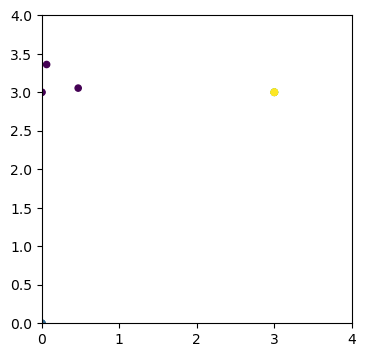

In [6]:
# Set the figure size
plt.rcParams["figure.figsize"] = [4, 4]

n_per_idx = 4

trajectories = trajectories_sampler2.sample(n_trajectories=4 * n_per_idx, idxs=torch.IntTensor([0] * n_per_idx + [1] * n_per_idx + [2] * n_per_idx + [3] * n_per_idx))


data = trajectories.last_states.states_tensor.numpy()
# Adding noise to see more points
data = data.astype("float64")
data[0] += np.random.uniform(low=0, high=0.5, size=data[0].size)
data[1] += np.random.uniform(low=0, high=0.5, size=data[1].size)


plt.scatter(x=data[:, 0], y=data[:, 1], c=[0.25]*n_per_idx + [0.5] * n_per_idx + [0.75] * n_per_idx + [1] * n_per_idx, s=[20] * 4 * n_per_idx)
plt.plot()
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.show()

**Test custom reward function for 8x8 grid**

First make reward function to sparse for basic GFN to find all the modes

In [8]:
batch_size = 4

env = HyperGrid(ndim=2, height=8, R0=0, preprocessor_name="OneHot", device_str=device_str)

logit_PF = LogitPFEstimator(env=env, module_name="NeuralNet")

logit_PB = LogitPBEstimator(
    env=env,
    module_name="NeuralNet",
    torso=logit_PF.module.torso,  # To share parameters between PF and PB
)
logZ = LogZEstimator(torch.tensor(0.0))

logit_PF.module.to(torch.device(device_str))
logit_PB.module.to(torch.device(device_str))


parametrization = TBParametrization(logit_PF, logit_PB, logZ)

actions_sampler = DiscreteActionsSampler(estimator=logit_PF)
trajectories_sampler = TrajectoriesSampler(env=env, actions_sampler=actions_sampler)

loss_fn = TrajectoryBalance(parametrization=parametrization)

params = [
    {
        "params": [
            val for key, val in parametrization.parameters.items() if key != "logZ"
        ],
        "lr": 0.001,
    },
    {"params": [parametrization.parameters["logZ"]], "lr": 0.1},
]
optimizer = torch.optim.Adam(params)

n_per_idxs = 1

for i in (pbar := tqdm(range(10000))):
    trajectories = trajectories_sampler.sample(n_trajectories=batch_size * n_per_idxs)
    optimizer.zero_grad()
    loss = loss_fn(trajectories)
    loss.backward()
    optimizer.step()
    if i % 25 == 0:
        pbar.set_postfix({"loss": loss.item()})

trajectories_sampler4 = trajectories_sampler

 13%|█▎        | 1298/10000 [00:15<01:41, 85.81it/s, loss=5.76e-5]  


KeyboardInterrupt: 

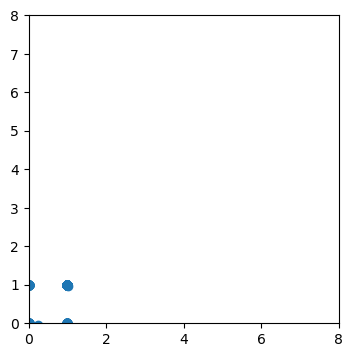

In [40]:
# Set the figure size
plt.rcParams["figure.figsize"] = [4, 4]

n_per_idx = 100

trajectories = trajectories_sampler4.sample(n_trajectories=4 * n_per_idx)

data = trajectories.last_states.states_tensor.cpu().numpy()
# Adding noise to see more points
data = data.astype("float64")
data[0] += np.random.uniform(low=-0.25, high=0.25, size=data[0].size)
data[1] += np.random.uniform(low=-0.25, high=0.25, size=data[1].size)


plt.scatter(x=data[:, 0], y=data[:, 1])
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.plot()
plt.show()

Then use a GFN that partitions the state space perfectly

In [4]:
gfn.config.batch_size = batch_size = 4
n_validation_samples = batch_size*25 * 100
wandb.init(project="8x8x8x8_compare_states_visited")

env = IdxAwareHyperGrid(ndim=4, height=8, reward="bruteforce", preprocessor_name="OneHot", device_str=device_str)
# env = HyperGrid(ndim=4, height=8, preprocessor_name="OneHot", device_str=device_str)

logit_PF = LogitPFEstimator(env=env, module_name="IdxAwareNeuralNet", batch_size=batch_size)
# logit_PF = LogitPFEstimator(env=env, module_name="NeuralNet")

logit_PB = LogitPBEstimator(
    env=env,
    module_name="IdxAwareNeuralNet",
    # module_name="NeuralNet",
    torso=logit_PF.module.torso,  # To share parameters between PF and PB
    batch_size=batch_size,
    embedding_layer=logit_PF.module.idx_embedding_layer, # To share parameters between PF and PB
)
logZ = LogZEstimator(torch.tensor(0.0))

logit_PF.module.to(torch.device(device_str))
logit_PB.module.to(torch.device(device_str))


parametrization = TBParametrization(logit_PF, logit_PB, logZ)

actions_sampler = DiscreteActionsSampler(estimator=logit_PF)
trajectories_sampler = TrajectoriesSampler(env=env, actions_sampler=actions_sampler)

loss_fn = TrajectoryBalance(parametrization=parametrization)

params = [
    {
        "params": [
            val for key, val in parametrization.parameters.items() if key != "logZ"
        ],
        "lr": 0.001,
    },
    {"params": [parametrization.parameters["logZ"]], "lr": 0.1},
]
optimizer = torch.optim.Adam(params)

n_per_idxs = 16

visited_terminating_states = (
    env.States.from_batch_shape((0,))
)
states_visited = 0
for i in (pbar := tqdm(range(10000))):
    idxs = torch.arange(gfn.config.batch_size, device=env.device).repeat(n_per_idxs)
    trajectories = trajectories_sampler.sample(n_trajectories=batch_size * n_per_idxs, idxs=idxs)
    trajectories = trajectories_sampler.sample(n_trajectories=batch_size * n_per_idxs)

    optimizer.zero_grad()
    loss = loss_fn(trajectories, idxs)
    # loss = loss_fn(trajectories)
    loss.backward()
    optimizer.step()
    
    if visited_terminating_states is not None:
        visited_terminating_states.extend(trajectories.last_states)

    states_visited += len(trajectories)
    to_log = {"loss": loss.item(), "states_visited": states_visited}
    wandb.log(to_log, step=i)

    if i % 25 == 0:
        validation_info = validate(
            env, parametrization, n_validation_samples, visited_terminating_states
        )
        pbar.set_postfix({"loss": loss.item(), "l1 dist": validation_info["l1_dist"]})
        wandb.log(validation_info, step=i)

trajectories_sampler3 = trajectories_sampler

l1_dist,█▆▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
logZ_diff,█▅▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▃▃▃▃▂▃▂▃▂▂▃▂▂▂▂▂▃▂▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
states_visited,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
l1_dist,0.00023
logZ_diff,0.57093
loss,0.52595
states_visited,64000


100%|██████████| 10000/10000 [22:35<00:00,  7.38it/s, loss=0.0385, l1 dist=0.000183]


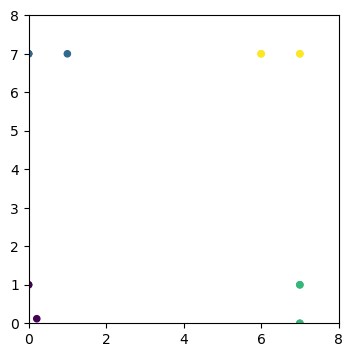

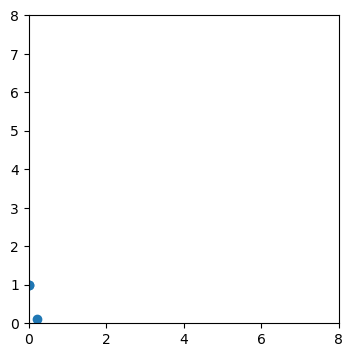

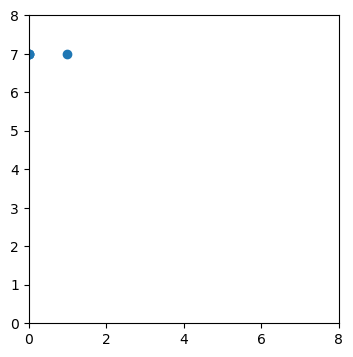

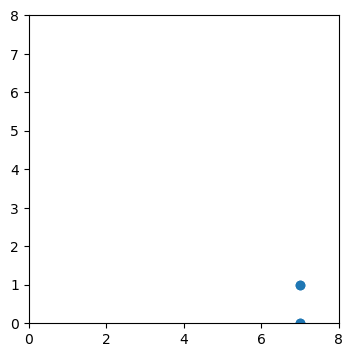

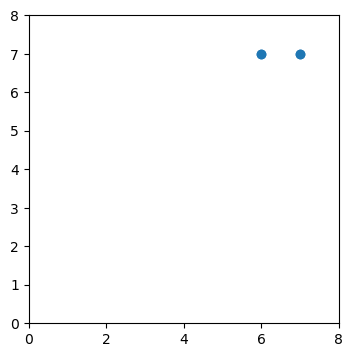

In [13]:
# Set the figure size
plt.rcParams["figure.figsize"] = [4, 4]

n_per_idx = 4

trajectories = trajectories_sampler3.sample(n_trajectories=4 * n_per_idx, idxs=torch.tensor([0] * n_per_idx + [1] * n_per_idx + [2] * n_per_idx + [3] * n_per_idx, dtype=torch.int, device=env.device))


data = trajectories.last_states.states_tensor.cpu().numpy()
# Adding noise to see more points
data = data.astype("float64")
data[0] += np.random.uniform(low=-0.25, high=0.25, size=data[0].size)
data[1] += np.random.uniform(low=-0.25, high=0.25, size=data[1].size)


plt.scatter(x=data[:, 0], y=data[:, 1], c=[0.25]*n_per_idx + [0.5] * n_per_idx + [0.75] * n_per_idx + [1] * n_per_idx, s=[20] * 4 * n_per_idx)
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.plot()
plt.show()

plt.scatter(x=data[:, 0][:n_per_idx], y=data[:, 1][:n_per_idx])
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.plot()
plt.show()


plt.xlim(0, 8)
plt.ylim(0, 8)
plt.scatter(x=data[:, 0][n_per_idx:n_per_idx*2], y=data[:, 1][n_per_idx:n_per_idx*2])
plt.plot()
plt.show()

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.scatter(x=data[:, 0][n_per_idx*2:n_per_idx*3], y=data[:, 1][n_per_idx*2:n_per_idx*3])
plt.plot()
plt.show()

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.scatter(x=data[:, 0][n_per_idx*3:n_per_idx*4], y=data[:, 1][n_per_idx*3:n_per_idx*4])
plt.plot()
plt.show()

In [20]:
env = HyperGrid(ndim=3, height=4, preprocessor_name="OneHot", device_str=device_str)
env.true_dist_pmf

tensor([0.0577, 0.0096, 0.0096, 0.0577, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096,
        0.0096, 0.0096, 0.0096, 0.0577, 0.0096, 0.0096, 0.0577, 0.0096, 0.0096,
        0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096,
        0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096,
        0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096,
        0.0096, 0.0096, 0.0096, 0.0577, 0.0096, 0.0096, 0.0577, 0.0096, 0.0096,
        0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0096, 0.0577, 0.0096, 0.0096,
        0.0577], device='cuda:0')

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand